### Integrating VADER Sentiment into LSTM Stock Prediction Model

### References

1. **VADER Sentiment Analysis**
   - Tutorial: [Python Sentiment Analysis using VADER](https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/)
     - Reference: [GeeksforGeeks](https://www.geeksforgeeks.org/). "Python Sentiment Analysis using VADER."

2. **LSTM Stock Price Prediction**
   - Tutorial: [Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)
     - Reference: Jason Brownlee. "Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras." *Machine Learning Mastery*.

3. **Time Series Data Analysis**
   - Tutorial: [Working with Time Series Data](https://machinelearningmastery.com/time-series-data-visualization-with-python/)
     - Reference: Jason Brownlee. "Time Series Data Visualization with Python." *Machine Learning Mastery*.

4. **Linear Regression**
   - Tutorial: [Linear Regression in Python](https://realpython.com/linear-regression-in-python/)
     - Reference: [Real Python](https://realpython.com/). "Linear Regression in Python."


In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np 
import pandas as pd  
import matplotlib.pyplot as plt 
import sys

sys.path.append("..")

from utils.StockPricesProcess import load_prices_df, add_lags

# Defining the path to the stock prices data and the date range
df_path = "../data/stock_prices/yfinance/AAPL_prices_2019-01-01_2020-01-01.csv"
start_date_string = "2019-01-01"
end_date_string = "2020-01-01"

# Load stock prices and add lags using functions from StockPricesProcess.py
stock_data = load_prices_df(path=df_path, start_date_string=start_date_string, end_date_string=end_date_string)
stock_data = add_lags(stock_data=stock_data.copy(), numLags=3)  # Adding lagged features
stock_data["Date"] = stock_data.index 


This code snippet reads a CSV file containing stock-related messages from StockTwits for the AAPL stock. It converts the 'datetime' column to datetime objects with UTC timezone. Then, it filters the data to include only messages within the specified date range.


In [3]:
stock_twits = pd.read_csv("../data/stocktwits/stocktwits_AAPL.csv") 
stock_twits["Date"] = pd.to_datetime(stock_twits["datetime"], utc=True)  

start_date = pd.to_datetime(start_date_string, utc=True) 
end_date = pd.to_datetime(end_date_string, utc=True) 

# Filtering stock_twits DataFrame to include only rows within the specified date range
stock_twits = stock_twits.loc[(stock_twits["Date"] >= start_date) & (stock_twits["Date"] <= end_date)]

print("Minimum Date:", stock_twits["Date"].min())
print("Maximum Date:", stock_twits["Date"].max())

stock_twits.shape


Minimum Date: 2019-01-01 00:08:25+00:00
Maximum Date: 2019-12-31 23:57:46+00:00


(184583, 6)

preprocesse the text messages from StockTwits data by applying the function preprocess_text() imported from the SentimentAnalysis.py module.


In [4]:
import sys
sys.path.append('../..')
from utils.SentimentAnalysis import preprocess_text


# Applying preprocess_text function to the stock_twits messages
stock_twits["processed_message"] = stock_twits["message"].apply(preprocess_text)

c:\Users\omare\.conda\envs\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\omare\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\omare\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\omare\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Calculate sentiment scores for the processed messages using the function called get_vader_sentiment_score imported from the SentimentAnalysis.py module.


In [5]:
from utils.SentimentAnalysis import get_vader_sentiment_score 

stock_twits["sentiment_score"] = stock_twits["processed_message"].apply(get_vader_sentiment_score)

In [6]:
stock_twits['Date'] = pd.to_datetime(stock_twits['Date'], utc=True).dt.date

tweets_aggregated_score = stock_twits.groupby("Date")["sentiment_score"].mean().reset_index()

In [7]:
stock_data["Date"] = stock_data.index
stock_data.reset_index(drop=True, inplace=True)

stock_data.head(2)

,Open,High,Low,Close,Volume,Close_Lag1,Close_Lag2,Close_Lag3,Date
0,37.118910,38.067913,36.960742,37.845039,148158800,37.845039,37.845039,37.845039,2019-01-02 05:00:00+00:00
1,34.504368,34.921355,34.029868,34.075401,365248800,37.845039,37.845039,37.845039,2019-01-03 05:00:00+00:00


Merge historical stock price data with aggregated sentiment scores derived from StockTwits data based on the date. 


In [8]:
stock_data['Date'] = pd.to_datetime(stock_data['Date'], utc=True).dt.date
tweets_aggregated_score['Date'] = pd.to_datetime(tweets_aggregated_score['Date'], utc=True).dt.date

# Merging stock_data and tweets_aggregated_score DataFrames based on the 'Date' column, using left join
merged_data = pd.merge(stock_data, tweets_aggregated_score, on="Date", how="left")
merged_data.set_index("Date", inplace=True)

nan_values = merged_data.isna().sum()
merged_data.head()


,Open,High,Low,Close,Volume,Close_Lag1,Close_Lag2,Close_Lag3,sentiment_score
Date,,,,,,,,,
2019-01-02,37.118910,38.067913,36.960742,37.845039,148158800,37.845039,37.845039,37.845039,0.026140
2019-01-03,34.504368,34.921355,34.029868,34.075401,365248800,37.845039,37.845039,37.845039,0.017955
2019-01-04,34.636170,35.599552,34.461229,35.530052,234428400,34.075401,37.845039,37.845039,0.056922
2019-01-07,35.635495,35.666650,34.964483,35.450966,219111200,35.530052,34.075401,37.845039,0.034159
2019-01-08,35.841590,36.383194,35.592358,36.126770,164101200,35.450966,35.530052,34.075401,0.076071


In [35]:
from sklearn.preprocessing import MinMaxScaler  

features = merged_data[['Close']]  # Features
target = merged_data['Close']  # Target variable

# Scaling the features using MinMaxScaler with feature range (0, 1)
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)

# Scaling the target variable using MinMaxScaler with feature range (0, 1)
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target.values.reshape(-1, 1))

# Concatenating the scaled features and scaled target variable along the columns axis
scaled_data = np.concatenate((scaled_features, scaled_target), axis=1)


In [36]:
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import LSTM, Dense, Dropout  

# Splitting the scaled_data into train_data and test_data using an 80-20 split
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Function to create sequences for training LSTM model
def create_sequences(data, sequence_length):
    sequences, labels = [], []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        label = data[i+sequence_length, -1]  # Extracting the target value for each sequence
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

sequence_length = 2  # Length of sequences to be used for training
# Creating sequences and labels for training and testing data
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Defining the LSTM model architecture
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))  # Adding LSTM layer with 50 units and input shape
model.add(Dropout(0.2))  # Adding Dropout layer with dropout rate of 0.2
model.add(Dense(1))  # Adding Dense layer with single output unit
model.compile(optimizer='adam', loss='mean_squared_error')  # Compiling the model with Adam optimizer and MSE loss function

# Training the LSTM model
model.fit(X_train, y_train, epochs=100, batch_size=3, validation_data=(X_test, y_test))

# Making predictions using the trained model on test data
predictions = model.predict(X_test)

# Inverse transforming the predicted values to original scale
predictions = scaler_target.inverse_transform(predictions)
# Inverse transforming the true target values to original scale
y_test_original = scaler_target.inverse_transform(y_test.reshape(-1, 1))


Epoch 1/100
67/67 [==============================] - 2s 7ms/step - loss: 0.0313 - val_loss: 0.0309
Epoch 2/100
67/67 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0188
Epoch 3/100
67/67 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0159
Epoch 4/100
67/67 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 5/100
67/67 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 5.1260e-04
Epoch 6/100
67/67 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 5.6312e-04
Epoch 7/100
67/67 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 8/100
67/67 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 9/100
67/67 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 10/100
67/67 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0010
E

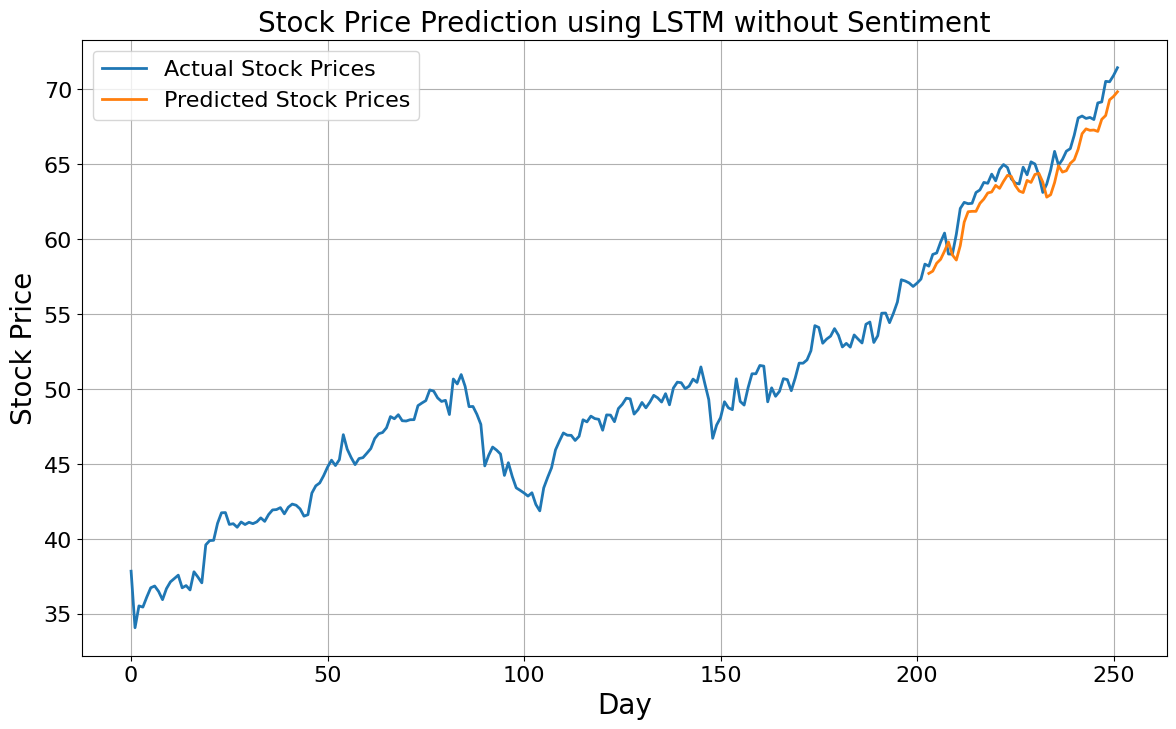

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))  
plt.plot(stock_data['Close'].values, label='Actual Stock Prices', linewidth=2)  
plt.plot(np.arange(train_size + sequence_length, len(stock_data)), predictions, label='Predicted Stock Prices', linewidth=2)  # Increase line thickness
plt.xlabel('Day', fontsize=20) 
plt.ylabel('Stock Price', fontsize=20)
plt.title('Stock Price Prediction using LSTM without Sentiment', fontsize=20) 
plt.legend(fontsize=16) 
plt.grid(True)  
plt.tick_params(axis='both', which='major', labelsize=16) 
plt.show()


In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # Importing evaluation metrics from sklearn

# Inverse transforming the true target values to their original scale
y_test_actual = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Calculating mean squared error (MSE) between actual and predicted values
mse = mean_squared_error(y_test_actual, predictions)

# Calculating root mean squared error (RMSE) from MSE
rmse = np.sqrt(mse)

# Calculating mean absolute error (MAE) between actual and predicted values
mae = mean_absolute_error(y_test_actual, predictions)

# Calculating R-squared (R²) score between actual and predicted values
r2 = r2_score(y_test_actual, predictions)

# Printing the evaluation results
print(f'Results without including Sentiment Scores')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R²): {r2}')


Results without including Sentiment Scores
Mean Squared Error (MSE): 1.4090186585119822
Root Mean Squared Error (RMSE): 1.1870209174702786
Mean Absolute Error (MAE): 1.0328123131576847
R-squared (R²): 0.8689448472094828


In [55]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout



features = merged_data[['Close','sentiment_score']] 
target = merged_data['Close']

scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)

scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target.values.reshape(-1, 1))

scaled_data = np.concatenate((scaled_features, scaled_target), axis=1)

In [56]:
import joblib

train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

def create_sequences(merged_data, sequence_length):
    sequences, labels = [], []
    for i in range(len(merged_data) - sequence_length):
        seq = merged_data[i:i+sequence_length]
        label = merged_data[i+sequence_length, -1] 
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

sequence_length = 2 
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=100, batch_size=3, validation_data=(X_test, y_test))
predictions = model.predict(X_test)
predictions = scaler_target.inverse_transform(predictions)
y_test_original = scaler_target.inverse_transform(y_test.reshape(-1, 1))





Epoch 1/100
67/67 [==============================] - 1s 5ms/step - loss: 0.0523 - val_loss: 0.0541
Epoch 2/100
67/67 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0407
Epoch 3/100
67/67 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0311
Epoch 4/100
67/67 [==============================] - 0s 1ms/step - loss: 0.0041 - val_loss: 0.0071
Epoch 5/100
67/67 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 5.2712e-04
Epoch 6/100
67/67 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 8.0588e-04
Epoch 7/100
67/67 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 8/100
67/67 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 9/100
67/67 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 10/100
67/67 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0039
E

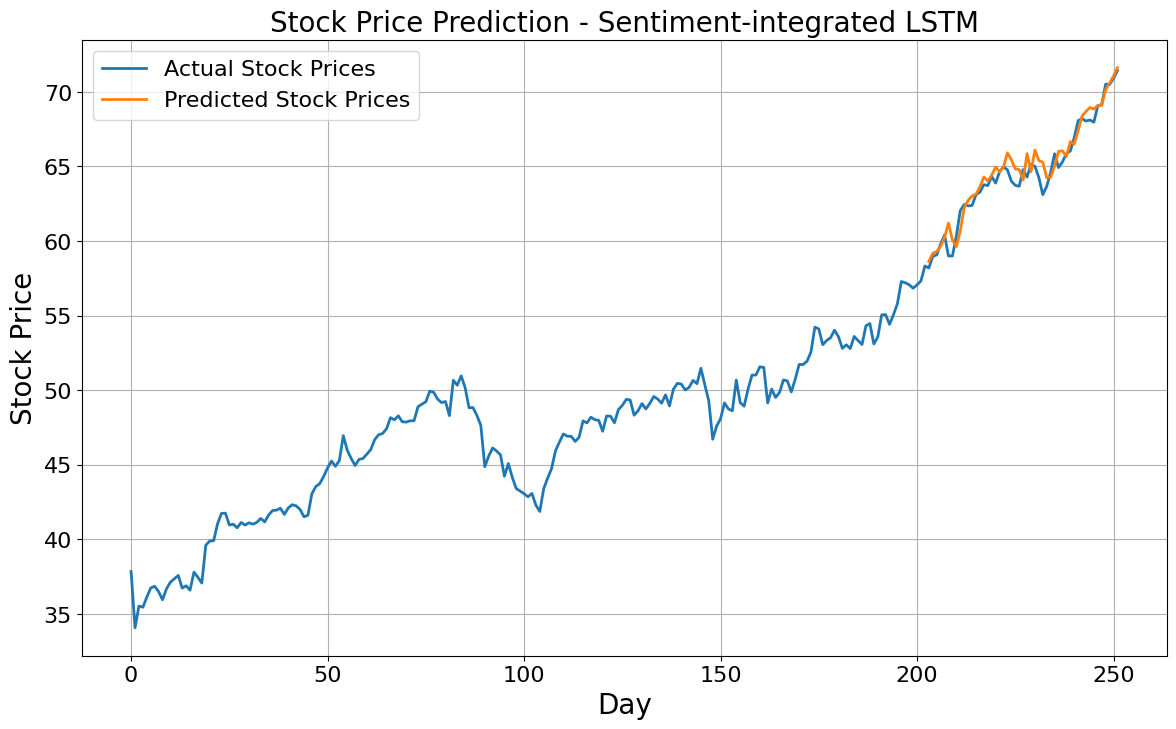

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))  
plt.plot(stock_data['Close'].values, label='Actual Stock Prices', linewidth=2)  
plt.plot(np.arange(train_size + sequence_length, len(stock_data)), predictions, label='Predicted Stock Prices', linewidth=2)  # Increase line thickness
plt.xlabel('Day', fontsize=20)  
plt.ylabel('Stock Price', fontsize=20) 
plt.title('Stock Price Prediction - Sentiment-integrated LSTM', fontsize=20) 
plt.legend(fontsize=16)  
plt.grid(True)  
plt.tick_params(axis='both', which='major', labelsize=16) 
plt.show()


In [58]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


mse = mean_squared_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, predictions)
r2 = r2_score(y_test_actual, predictions)

print(f'Results without including Sentiment Scores')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R²): {r2}')


Results without including Sentiment Scores
Mean Squared Error (MSE): 0.6791751664051693
Root Mean Squared Error (RMSE): 0.8241208445399069
Mean Absolute Error (MAE): 0.6315915633221063
R-squared (R²): 0.936828795937483


In [59]:
# Splitting the dataset into features and target variables without sentiment score
features_without_sentiment = merged_data[["Close_Lag1", "Close_Lag2", "Volume"]]  # Selecting features without sentiment score
target_without_sentiment = merged_data['Close']  # Selecting target variable without sentiment score

# Splitting the dataset into features and target variables with sentiment score
features_with_sentiment = merged_data[["Close_Lag1", "Close_Lag2", "Volume", "sentiment_score"]]  # Selecting features with sentiment score
target_with_sentiment = merged_data['Close']  # Selecting target variable with sentiment score


In [60]:
from sklearn.model_selection import cross_val_score  
from sklearn.linear_model import LinearRegression 

# Model without sentiment
model_without_sentiment = LinearRegression()

# Perform cross-validation for model without sentiment
cv_scores_without_sentiment = cross_val_score(model_without_sentiment, features_without_sentiment, target_without_sentiment, 
                                             scoring='neg_mean_squared_error', cv=5)  # Cross-validation with MSE scoring, 5 folds
cv_mse_without_sentiment = -cv_scores_without_sentiment  # Convert negative MSE scores to positive
cv_rmse_without_sentiment = np.sqrt(cv_mse_without_sentiment)  # Calculate RMSE from MSE
cv_mae_without_sentiment = -cross_val_score(model_without_sentiment, features_without_sentiment, target_without_sentiment, 
                                            scoring='neg_mean_absolute_error', cv=5)  # Cross-validation with MAE scoring, 5 folds
cv_r2_without_sentiment = cross_val_score(model_without_sentiment, features_without_sentiment, target_without_sentiment, 
                                          scoring='r2', cv=5)  # Cross-validation with R-squared scoring, 5 folds

# Model with sentiment
model_with_sentiment = LinearRegression()  

# Perform cross-validation for model with sentiment
cv_scores_with_sentiment = cross_val_score(model_with_sentiment, features_with_sentiment, target_with_sentiment, 
                                           scoring='neg_mean_squared_error', cv=5)  # Cross-validation with MSE scoring, 5 folds
cv_mse_with_sentiment = -cv_scores_with_sentiment  # Convert negative MSE scores to positive
cv_rmse_with_sentiment = np.sqrt(cv_mse_with_sentiment)  # Calculate RMSE from MSE
cv_mae_with_sentiment = -cross_val_score(model_with_sentiment, features_with_sentiment, target_with_sentiment, 
                                          scoring='neg_mean_absolute_error', cv=5)  # Cross-validation with MAE scoring, 5 folds
cv_r2_with_sentiment = cross_val_score(model_with_sentiment, features_with_sentiment, target_with_sentiment, 
                                       scoring='r2', cv=5)  # Cross-validation with R-squared scoring, 5 folds

# Printing the cross-validation results for models without and with sentiment
print("Linear Regression Model without Sentiment:")
print(f"Mean and Standard Deviation of MSE across 5 folds: {np.mean(cv_mse_without_sentiment):.4f} ± {np.std(cv_mse_without_sentiment):.4f}")
print(f"Mean and Standard Deviation of RMSE across 5 folds: {np.mean(cv_rmse_without_sentiment):.4f} ± {np.std(cv_rmse_without_sentiment):.4f}")
print(f"Mean and Standard Deviation of MAE across 5 folds: {np.mean(cv_mae_without_sentiment):.4f} ± {np.std(cv_mae_without_sentiment):.4f}")
print(f"Mean and Standard Deviation of R-squared across 5 folds: {np.mean(cv_r2_without_sentiment):.4f} ± {np.std(cv_r2_without_sentiment):.4f}")
print()
print("Linear Regression Model with Sentiment:")
print(f"Mean and Standard Deviation of MSE across 5 folds: {np.mean(cv_mse_with_sentiment):.4f} ± {np.std(cv_mse_with_sentiment):.4f}")
print(f"Mean and Standard Deviation of RMSE across 5 folds: {np.mean(cv_rmse_with_sentiment):.4f} ± {np.std(cv_rmse_with_sentiment):.4f}")
print(f"Mean and Standard Deviation of MAE across 5 folds: {np.mean(cv_mae_with_sentiment):.4f} ± {np.std(cv_mae_with_sentiment):.4f}")
print(f"Mean and Standard Deviation of R-squared across 5 folds: {np.mean(cv_r2_with_sentiment):.4f} ± {np.std(cv_r2_with_sentiment):.4f}")


Linear Regression Model without Sentiment:
Mean and Standard Deviation of MSE across 5 folds: 0.6150 ± 0.0478
Mean and Standard Deviation of RMSE across 5 folds: 0.7836 ± 0.0310
Mean and Standard Deviation of MAE across 5 folds: 0.5759 ± 0.0353
Mean and Standard Deviation of R-squared across 5 folds: 0.8984 ± 0.0289

Linear Regression Model with Sentiment:
Mean and Standard Deviation of MSE across 5 folds: 0.4618 ± 0.0300
Mean and Standard Deviation of RMSE across 5 folds: 0.6792 ± 0.0220
Mean and Standard Deviation of MAE across 5 folds: 0.5114 ± 0.0205
Mean and Standard Deviation of R-squared across 5 folds: 0.9241 ± 0.0197


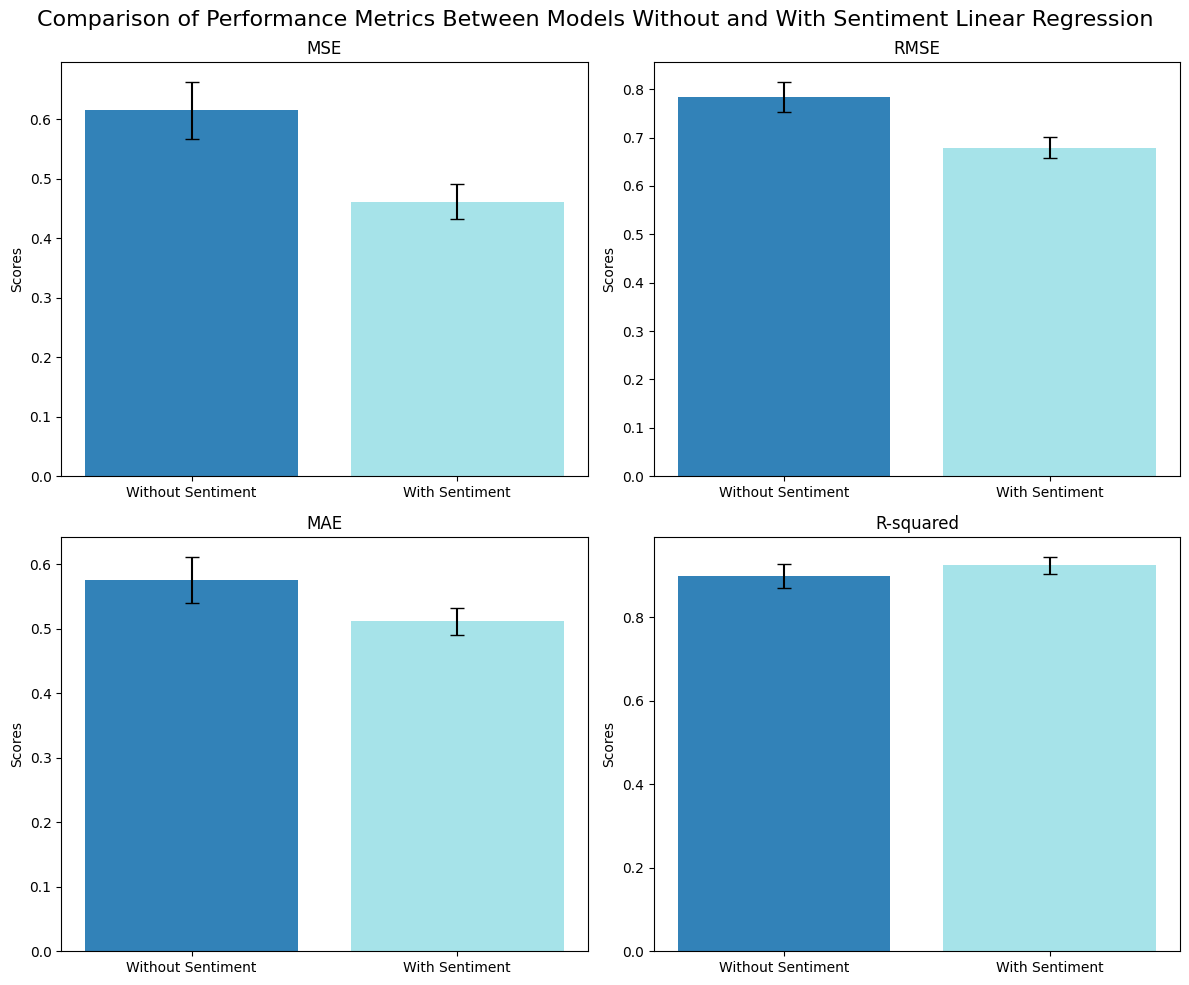

In [61]:
mean_scores_without_sentiment = [np.mean(cv_mse_without_sentiment), np.mean(cv_rmse_without_sentiment), 
                                 np.mean(cv_mae_without_sentiment), np.mean(cv_r2_without_sentiment)]
std_scores_without_sentiment = [np.std(cv_mse_without_sentiment), np.std(cv_rmse_without_sentiment), 
                                np.std(cv_mae_without_sentiment), np.std(cv_r2_without_sentiment)]
mean_scores_with_sentiment = [np.mean(cv_mse_with_sentiment), np.mean(cv_rmse_with_sentiment), 
                               np.mean(cv_mae_with_sentiment), np.mean(cv_r2_with_sentiment)]
std_scores_with_sentiment = [np.std(cv_mse_with_sentiment), np.std(cv_rmse_with_sentiment), 
                              np.std(cv_mae_with_sentiment), np.std(cv_r2_with_sentiment)]

metrics = ['MSE', 'RMSE', 'MAE', 'R-squared']

fig, ax = plt.subplots(2, 2, figsize=(12, 10))
for i in range(len(metrics)):
    # Plot bar chart for each metric
    ax[i//2, i%2].bar(['Without Sentiment', 'With Sentiment'], [mean_scores_without_sentiment[i], mean_scores_with_sentiment[i]], 
                      yerr=[std_scores_without_sentiment[i], std_scores_with_sentiment[i]], capsize=5, color=['#3282B8', '#A6E3E9'])
    ax[i//2, i%2].set_title(metrics[i])  # Set title for each subplot
    ax[i//2, i%2].set_ylabel('Scores')  # Set ylabel for each subplot

plt.suptitle('Comparison of Performance Metrics Between Models Without and With Sentiment Linear Regression', fontsize=16)  # Set main title
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plot


In [64]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


n_splits = 5

# Function to preprocess data
def preprocess_data(features, target):
    # Scaling features and target
    scaler_features = MinMaxScaler(feature_range=(0, 1))
    scaled_features = scaler_features.fit_transform(features)

    scaler_target = MinMaxScaler(feature_range=(0, 1))
    scaled_target = scaler_target.fit_transform(target.values.reshape(-1, 1))

    # Concatenating scaled features and target
    scaled_data = np.concatenate((scaled_features, scaled_target), axis=1)

    return scaled_data

# Function to create sequences for LSTM
def create_sequences(data, sequence_length):
    sequences, labels = [], []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length, :-1]  # Excluding the target from sequences
        label = data[i+sequence_length, -1]   # Using the target as label
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Function to create LSTM model
def create_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Function to evaluate model performance
def evaluate_model(model, X_test, y_test, scaler_target):
    predictions = model.predict(X_test)
    predictions = scaler_target.inverse_transform(predictions)
    y_test_actual = scaler_target.inverse_transform(y_test.reshape(-1, 1))

    mse = mean_squared_error(y_test_actual, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_actual, predictions)
    r2 = r2_score(y_test_actual, predictions)

    return mse, rmse, mae, r2

# Function to train and evaluate model using KFold cross-validation
def train_and_evaluate_model(scaled_data, sequence_length, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    mse_scores, rmse_scores, mae_scores, r2_scores = [], [], [], []

    # Loop over KFold splits
    for train_index, test_index in kf.split(scaled_data):
        train_data, test_data = scaled_data[train_index], scaled_data[test_index]

        X_train, y_train = create_sequences(train_data, sequence_length)
        X_test, y_test = create_sequences(test_data, sequence_length)

        model = create_model(input_shape=(X_train.shape[1], X_train.shape[2]))

        model.fit(X_train, y_train, epochs=100, batch_size=5, verbose=0)

        mse, rmse, mae, r2 = evaluate_model(model, X_test, y_test, scaler_target)

        mse_scores.append(mse)
        rmse_scores.append(rmse)
        mae_scores.append(mae)
        r2_scores.append(r2)

        # Print evaluation metrics for each fold
        print(f'Mean Squared Error (MSE): {mse}')
        print(f'Root Mean Squared Error (RMSE): {rmse}')
        print(f'Mean Absolute Error (MAE): {mae}')
        print(f'R-squared (R²): {r2}')
        print()

    return mse_scores, rmse_scores, mae_scores, r2_scores


# Baseline model without sentiment
features_baseline = merged_data[['Close']]
target_baseline = merged_data['Close']

# Preprocess data and train/evaluate model
scaled_data_baseline = preprocess_data(features_baseline, target_baseline)
sequence_length = 1
mse_scores_baseline, rmse_scores_baseline, mae_scores_baseline, r2_scores_baseline = train_and_evaluate_model(scaled_data_baseline, sequence_length)

# Calculate mean and standard deviation of evaluation metrics
mean_mse_baseline = round(np.mean(mse_scores_baseline), 4)
std_mse_baseline = round(np.std(mse_scores_baseline), 4)

mean_rmse_baseline = round(np.mean(rmse_scores_baseline), 4)
std_rmse_baseline = round(np.std(rmse_scores_baseline), 4)

mean_mae_baseline = round(np.mean(mae_scores_baseline), 4)
std_mae_baseline = round(np.std(mae_scores_baseline), 4)

mean_r2_baseline = round(np.mean(r2_scores_baseline), 4)
std_r2_baseline = round(np.std(r2_scores_baseline), 4)

# Print results for the baseline model
print('Baseline LSTM without including Sentiment')
print(f'Mean and Standard Deviation of MSE across {n_splits} folds: {mean_mse_baseline} ± {std_mse_baseline}')
print(f'Mean and Standard Deviation of RMSE across {n_splits} folds: {mean_rmse_baseline} ± {std_rmse_baseline}')
print(f'Mean and Standard Deviation of MAE across {n_splits} folds: {mean_mae_baseline} ± {std_mae_baseline}')
print(f'Mean and Standard Deviation of R-squared across {n_splits} folds: {mean_r2_baseline} ± {std_r2_baseline}')

# Sentiment-integrated model
features_sentiment = merged_data[['Close', 'sentiment_score']]
target_sentiment = merged_data['Close']

# Preprocess data and train/evaluate model
scaled_data_sentiment = preprocess_data(features_sentiment, target_sentiment)
mse_scores_sentiment, rmse_scores_sentiment, mae_scores_sentiment, r2_scores_sentiment = train_and_evaluate_model(scaled_data_sentiment, sequence_length)

# Calculate mean and standard deviation of evaluation metrics
mean_mse_sentiment = round(np.mean(mse_scores_sentiment), 4)
std_mse_sentiment = round(np.std(mse_scores_sentiment), 4)

mean_rmse_sentiment = round(np.mean(rmse_scores_sentiment), 4)
std_rmse_sentiment = round(np.std(rmse_scores_sentiment), 4)

mean_mae_sentiment = round(np.mean(mae_scores_sentiment), 4)
std_mae_sentiment = round(np.std(mae_scores_sentiment), 4)

mean_r2_sentiment = round(np.mean(r2_scores_sentiment), 4)
std_r2_sentiment = round(np.std(r2_scores_sentiment), 4)

# Print results for the sentiment-integrated model
print('LSTM including Sentiment')
print(f'Mean and Standard Deviation of MSE across {n_splits} folds: {mean_mse_sentiment} ± {std_mse_sentiment}')
print(f'Mean and Standard Deviation of RMSE across {n_splits} folds: {mean_rmse_sentiment} ± {std_rmse_sentiment}')
print(f'Mean and Standard Deviation of MAE across {n_splits} folds: {mean_mae_sentiment} ± {std_mae_sentiment}')
print(f'Mean and Standard Deviation of R-squared across {n_splits} folds: {mean_r2_sentiment} ± {std_r2_sentiment}')



2/2 [==============================] - 0s 997us/step
Mean Squared Error (MSE): 3.844176383375017
Root Mean Squared Error (RMSE): 1.9606571304986034
Mean Absolute Error (MAE): 1.538525009155274
R-squared (R²): 0.9373427173594452

2/2 [==============================] - 0s 2ms/step
Mean Squared Error (MSE): 3.269693897487017
Root Mean Squared Error (RMSE): 1.808229492483467
Mean Absolute Error (MAE): 1.334037475585938
R-squared (R²): 0.9516488401845826

2/2 [==============================] - 0s 2ms/step
Mean Squared Error (MSE): 3.3833119619200565
Root Mean Squared Error (RMSE): 1.8393781454393918
Mean Absolute Error (MAE): 1.2355100670639347
R-squared (R²): 0.953113171562531

2/2 [==============================] - 0s 2ms/step
Mean Squared Error (MSE): 3.3029393940645506
Root Mean Squared Error (RMSE): 1.8173990739693224
Mean Absolute Error (MAE): 1.3556358960210066
R-squared (R²): 0.9554283815903954

2/2 [==============================] - 0s 2ms/step
Mean Squared Error (MSE): 2.771467009

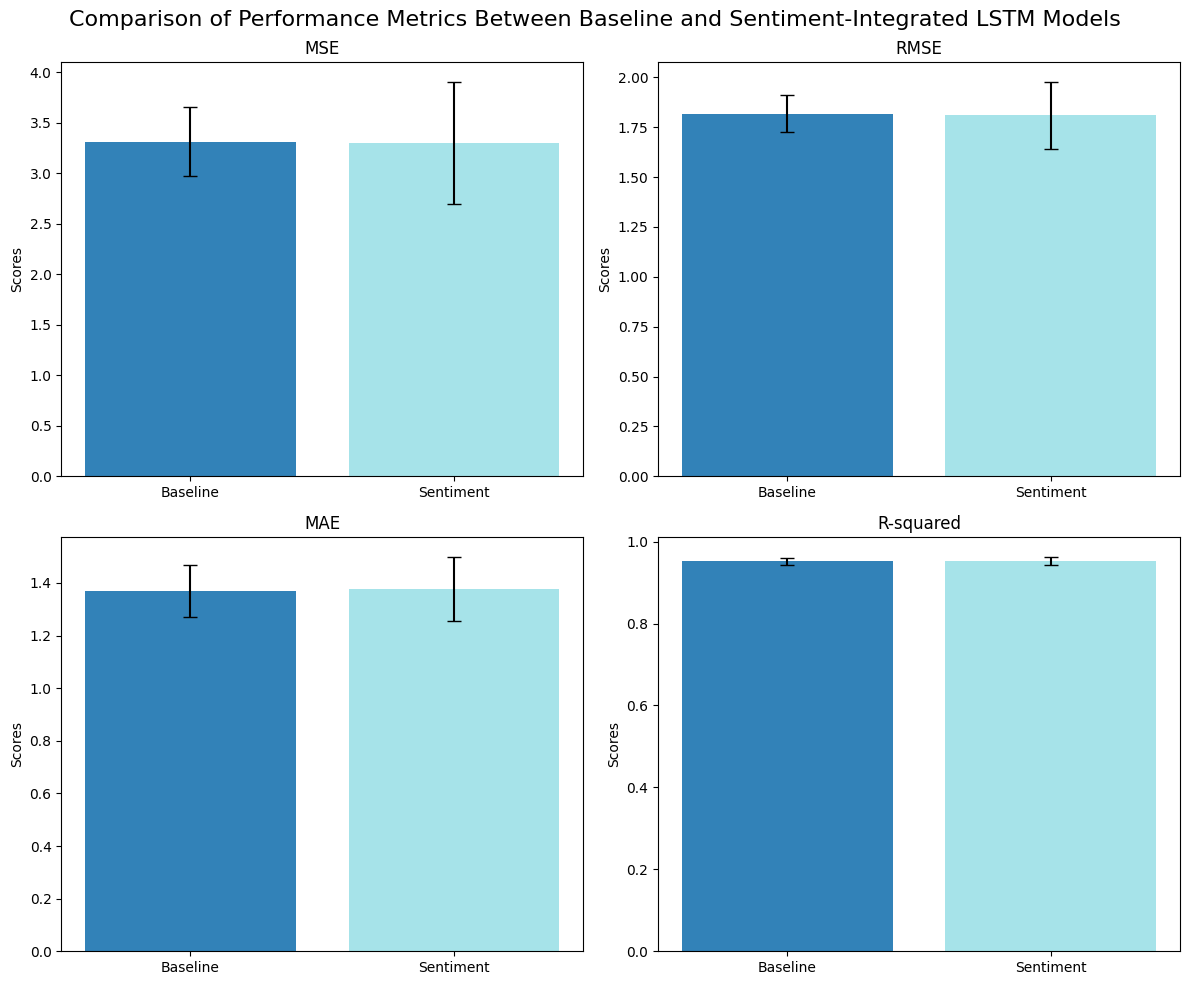

In [65]:
import matplotlib.pyplot as plt

# Mean scores and standard deviations for the baseline LSTM model
mean_scores_baseline = [mean_mse_baseline, mean_rmse_baseline, mean_mae_baseline, mean_r2_baseline]
std_scores_baseline = [std_mse_baseline, std_rmse_baseline, std_mae_baseline, std_r2_baseline]

# Mean scores and standard deviations for the sentiment-integrated LSTM model
mean_scores_sentiment = [mean_mse_sentiment, mean_rmse_sentiment, mean_mae_sentiment, mean_r2_sentiment]
std_scores_sentiment = [std_mse_sentiment, std_rmse_sentiment, std_mae_sentiment, std_r2_sentiment]

# Metrics names
metrics = ['MSE', 'RMSE', 'MAE', 'R-squared']

# Colors for sentiment-integrated bars
sentiment_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Plotting
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

for i in range(len(metrics)):
    ax[i//2, i%2].bar(['Baseline', 'Sentiment'], [mean_scores_baseline[i], mean_scores_sentiment[i]], yerr=[std_scores_baseline[i], std_scores_sentiment[i]], capsize=5, color=['#3282B8', '#A6E3E9'])
    ax[i//2, i%2].set_title(metrics[i])
    ax[i//2, i%2].set_ylabel('Scores')

# Adding a title to the plot
plt.suptitle('Comparison of Performance Metrics Between Baseline and Sentiment-Integrated LSTM Models', fontsize=16)

# Adjusting the layout
plt.tight_layout()

# Display the plot
plt.show()
